This notebook runs the event segmentation analyses.

## Import libraries

In [79]:
import numpy as np
import pandas as pd
import brainiak.eventseg.event as event
import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import entropy
from scipy.stats import pearsonr
import pickle

def score_model(mcorr, model, k, s):
    i1, i2 = np.where(np.round(model.segments_[0])==1)
    w = np.zeros_like(model.segments_[0])
    w[i1,i2] = 1
    w = np.dot(w, w.T).astype(bool)
    return mcorr[w].mean()/mcorr[~w].mean() - k/s
    
def reduce_model(m, ev):
    """Reduce a model based on event labels"""
    w = (np.round(ev.segments_[0])==1).astype(bool)
    return np.array([m[wi, :].mean(0) for wi in w.T])

def symKL(a, b, e=.0000001):
    a = np.histogram(a, bins = np.linspace(-1, 1, 100))[0]+e
    a /= a.sum()
    b = np.histogram(b, bins = np.linspace(-1, 1, 100))[0]+e
    b /= b.sum()
    return (entropy(a, b) + entropy(b, a))/2

def KL(a, b, e=.0000001):
    a = np.histogram(a, bins = np.linspace(-1, 1, 100))[0]+e
    a /= a.sum()
    b = np.histogram(b, bins = np.linspace(-1, 1, 100))[0]+e
    b /= b.sum()
    return entropy(a, b)

def r2z(r, e=.0000001):
    """
    Function that calculates the Fisher z-transformation

    Parameters
    ----------
    r : int or ndarray
        Correlation value

    Returns
    ----------
    result : int or ndarray
        Fishers z transformed correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        r[np.abs(r==1)]-=e
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    
def z2r(z):
    """
    Function that calculates the inverse Fisher z-transformation
    Parameters
    ----------
    z : int or ndarray
        Fishers z transformed correlation value
    Returns
    ----------
    result : int or ndarray
        Correlation value
    """
    with np.errstate(invalid='ignore', divide='ignore'):
        if isinstance(z, list):
            z = np.array(z)
        r = (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
        if isinstance(r, np.ndarray):
            r[np.isinf(z) & (z > 0)] = 1
            r[np.isinf(z) & (z < 0)] = -1
        else:
            if np.isinf(z) & (z > 0):
                return 1
            elif np.isinf(z) & (z < 0):
                return -1
        return r

%matplotlib inline

## Setting paths

In [80]:
datadir = '../../../data/processed/'

## Load data

In [86]:
video_model, recall_models = np.load(datadir+'models_t100_v25_r5.npy')

## Find optimal k for video model

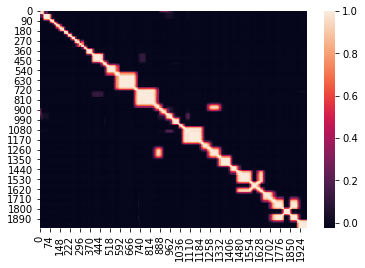

In [87]:
sns.heatmap(1 - cdist(video_model, video_model, 'correlation'))

In [ ]:
from scipy.stats import wasserstein_distance

nEvents = np.arange(2,51)
wd = np.zeros(len(nEvents))
corrmat = 1 - cdist(video_model, video_model, 'correlation')

for i, events in enumerate(nEvents):
    ev = event.EventSegment(events)
    ev.fit(video_model)
    t = np.round(ev.segments_[0]).astype(int)
    mask = np.sum(list(map(lambda x: np.outer(x, x), t.T)), 0).astype(bool)

    # Create mask such that the maximum temporal distance for # within and across correlations is the same
#     local_mask = np.zeros(mask.shape, dtype=bool)
#     for k in range(mask.shape[0]):
#         if ~np.any(np.diag(mask,k)):
#             break
#         local_mask[np.diag(np.ones(local_mask.shape[0]-k, dtype=bool), k)] = True
    within_vals = np.reshape(corrmat[mask], -1, 1) 
    across_vals = np.reshape(corrmat[~mask], -1, 1)
    wd[i] = wasserstein_distance(within_vals, across_vals)
    print(events, wd[i])

2 0.09740981894762958
3 0.1570962046363612
4 0.21342345417260047
5 0.239608484097785
6 0.2965667250203
7 0.3447360252923023
8 0.34323487262569985
9 0.37151462651279776
10 0.4546676529629347
11 0.5018546457625149
12 0.5271881700069941
13 0.5514320902238842
14 0.5837610326543784
15 0.6226171893756054
16 0.6618849141596683
17 0.6779396699134207
18 0.6985797073250268
19 0.7121306809689412
20 0.7254757884445767
21 0.7280916295004445
22 0.7539255079049745
23 0.7685673646594147
24 0.7712360106727624
25 0.7759192103773807
26 0.8094784910327878
27 0.8173018793015566
28 0.8307354144583433
29 0.8177602646459956
30 0.8302389450366822
31 0.8518117790114588
32 0.8535192826951757
33 0.8447478132344306
34 0.8492668547541621
35 0.8405571389207798
36 0.8510802962619908
37 0.8607755220925162
38 0.8786454781378209


## Plot the within and across correlation values as a function of k

27


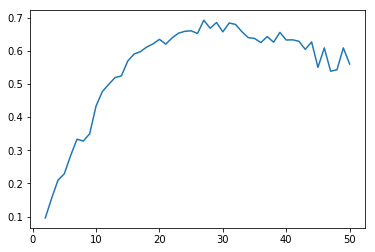

In [8]:
plt.plot(nEvents, wd)
maxk_video = nEvents[np.argmax(wd)]
print(maxk_video)

## Plot the ratio of within/across ratio as a function of k

## Fit event segmentation model to video

In [20]:
ev = event.EventSegment(maxk_video)
ev.fit(video_model)
video_events = reduce_model(video_model, ev)

## Save models

In [21]:
with open(datadir+'/video_eventseg_model_wasserstein_t100_v25_r5', 'wb') as f:
    pickle.dump(ev, f)
np.save(datadir+'video_events_wasserstein_t100_v25_r5', video_events)

## Get video event times

In [22]:
video_event_times = []
for s in ev.segments_[0].T:
    tp = np.where(np.round(s)==1)[0]
    video_event_times.append((tp[0], tp[-1]))
np.save(datadir+'video_event_times_wasserstein_t100_v25_r5', video_event_times)

## Fit event segmentation model to recall

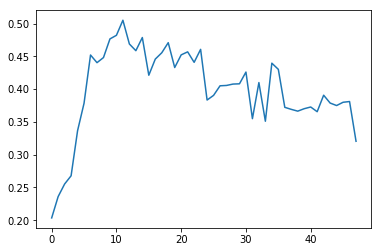

0 13


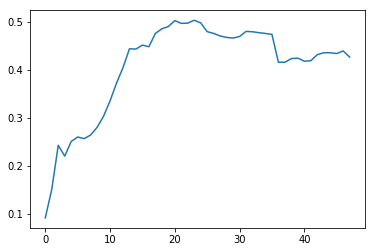

1 25


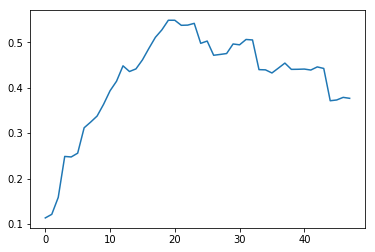

2 21


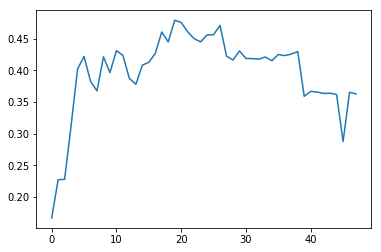

3 21


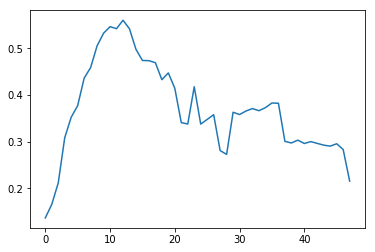

4 14


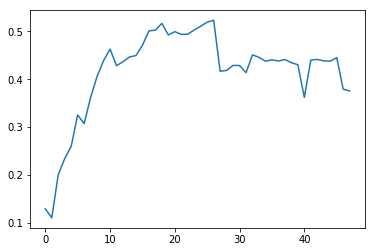

5 28


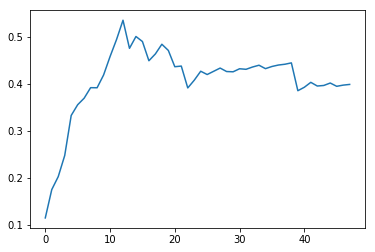

6 14


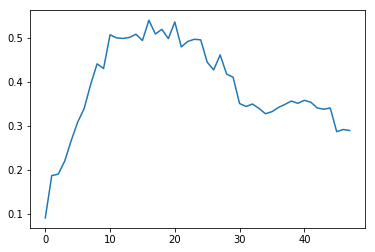

7 18


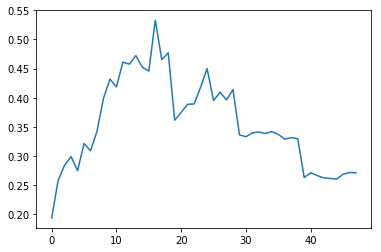

8 18


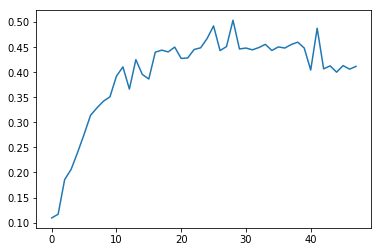

9 30


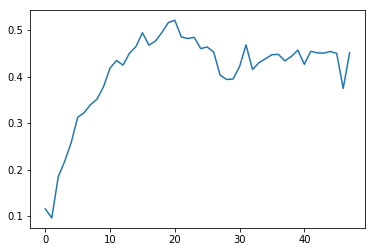

10 22


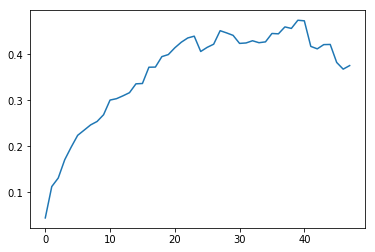

11 41


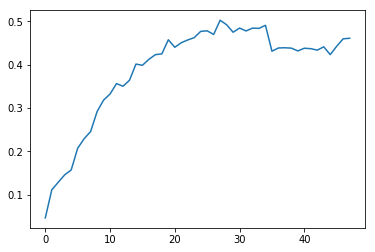

12 29


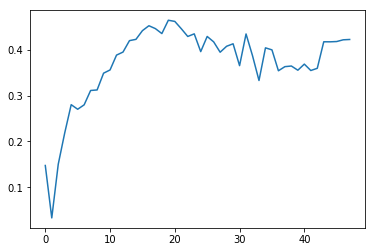

13 21


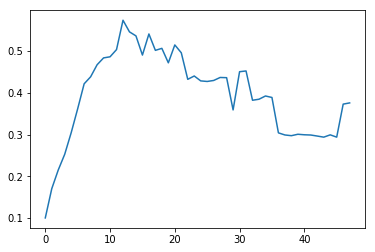

14 14


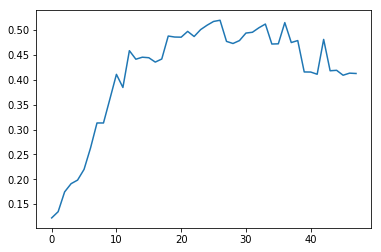

15 28


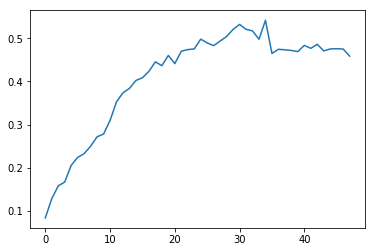

16 36


In [9]:
from scipy.stats import pearsonr as corr

ks = list(range(2, 50))
maxk = []
for i, sub in enumerate(recall_models):
    mcorr = 1 - cdist(sub, sub, 'correlation')
    cs = []
    for k in ks:
        ev = event.EventSegment(k)
        ev.fit(sub)
        i1, i2 = np.where(np.round(ev.segments_[0])==1)
        w = np.zeros_like(ev.segments_[0])
        w[i1,i2] = 1
        mask = np.dot(w, w.T).astype(bool)
        
        # Create mask such that the maximum temporal distance for # within and across correlations is the same
        local_mask = np.zeros(mask.shape, dtype=bool)
        for m in range(mask.shape[0]):
            if ~np.any(np.diag(mask, m)):
                break
            local_mask[np.diag(np.ones(local_mask.shape[0]-m, dtype=bool), m)] = True
        within_vals = np.reshape(mcorr[mask*local_mask], -1, 1) 
        across_vals = np.reshape(mcorr[~mask*local_mask], -1, 1)
        cs.append(wasserstein_distance(within_vals, across_vals))
    plt.plot(cs)
    plt.show()
    m = ks[np.argmax(cs)]
    maxk.append(m)
    print(i, m)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


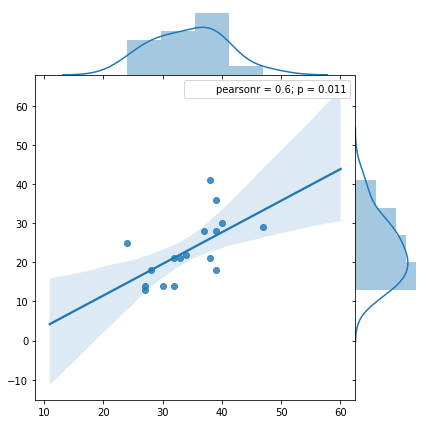

In [17]:
hand_rec = [27, 24, 32, 33, 32, 39, 30, 39, 28, 40, 34, 38, 47, 38, 27, 37, 39]
ax = sns.jointplot(hand_rec, maxk, kind = 'reg', order = 1, space=False)
corr = pearsonr(hand_rec, maxk)
ax.annotate(pearsonr)

## Fit model to recall using best k

In [18]:
recall_events = []
recall_event_times = []
recall_eventseg_models = []
for i, k in enumerate(maxk):
    ev = event.EventSegment(k)
    ev.fit(recall_models[i])
    m = reduce_model(recall_models[i], ev)
    recall_events.append(m)
    recall_times = []
    for s in ev.segments_[0].T:
        tp = np.where(np.round(s)==1)[0]
        recall_times.append((tp[0], tp[-1]))
    recall_event_times.append(recall_times)
    recall_eventseg_models.append(ev)

## Create average recall model

In [23]:
matches = np.array([np.argmax(1 - cdist(video_events, r, 'correlation'), 0) for r in recall_events])
avg_recalls = [[] for _ in video_events]
for match, r in zip(matches, recall_events):
    for i, m in enumerate(match):
        avg_recalls[m].append(r[i,:])
avg_recall_events = np.array(list(map(lambda r: np.mean(r, 0) if len(r)>0 else np.zeros((100,)), avg_recalls)))
avg_recall_events = np.array([a.reshape(100,) for a in avg_recall_events if a.shape==(100,)])

## Create 2D embeddings

In [66]:
%autoreload
import hypertools as hyp
np.random.seed(3)
embeddings = hyp.reduce(recall_events+[video_events]+[avg_recall_events], reduce='UMAP', ndims=2, normalize=False)

/opt/conda/lib/python3.6/site-packages/hypertools/tools/reduce.py:113: UserWarning: The normalize argument will be deprecated for this function.  Please use the                           analyze function to perform combinations of these transformations.  See API docs for more info: http://hypertools.readthedocs.io/en/latest/hypertools.analyze.html#hypertools.analyze
  analyze function to perform combinations of these transformations.  See API docs for more info: http://hypertools.readthedocs.io/en/latest/hypertools.analyze.html#hypertools.analyze')


## Save models

In [67]:
np.save(datadir+'avg_recall_events_wasserstein_t100_v25_r5', avg_recall_events)
np.save(datadir+'embeddings_wasserstein_t100_v25_r5', [embeddings[:-2], embeddings[-2], embeddings[-1]])
np.save(datadir+'labels_wasserstein_t100_v25_r5', matches)
np.save(datadir+'video_events_wasserstein_t100_v25_r5', video_events)
np.save(datadir+'recall_events_wasserstein_t100_v25_r5', recall_events)
np.save(datadir+'recall_event_times_wasserstein_t100_v25_r5', recall_event_times)
with open(datadir+'recall_eventseg_models_wasserstein_t100_v25_r5', 'wb') as f:
    pickle.dump(recall_eventseg_models, f)